### Dynamic Feature Extraction - Multiclass

**AIM**: Build and train an image classifier to detect images from different animal species using a pre-trained ResNet101 model.

### Objectives
- Data visualisation
- Data preprocessing and image augmentation
- Use a pre-trained CNN Model for transfer learning (dynamic feature extraction)
- Base model runs every epoch and supports data augmentation and fine-tuning
- Compile and train the model
- Add early stopping callback (optional)
- Save and load model
- Model evaluation
- Make prediction on new data

### Prerequisite
- Google colab or Jupyter notebook
- animal-image-classification-dataset
- TensorFlow2

### Check if TensorFlow, NumPy, Pandas and Matplotlib are installed

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, kauldron, tensorflow-text, tensorflow_decision_forests, tf_keras


In [2]:
# !pip show numpy

In [3]:
# !pip show pandas

In [4]:
!pip show matplotlib

Name: matplotlib
Version: 3.10.0
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later

 1. This LICENSE AGREEMENT is between the Matplotlib Development Team
 ("MDT"), and the Individual or Organization ("Licensee") accessing and
 otherwise using matplotlib software in source or binary form and its
 associated documentation.

 2. Subject to the terms and conditions of this License Agreement, MDT
 hereby grants Licensee a nonexclusive, royalty-free, world-wide license
 to reproduce, analyze, test, perform and/or display publicly, prepare
 derivative works, distribute, and otherwise use matplotlib
 alone or in any derivative version, provided, however, that MDT's
 License Agreement and MDT's notice of copyright, i.e., "Copyright (c)
 2012- Matplotlib Development Team; All Rights Reserved" are retained in
 matplotlib

In [5]:
import os
import sys
import random
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

2026-01-10 02:41:52.389127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768012912.581079      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768012912.639503      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768012913.114900      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768012913.114933      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768012913.114935      55 computation_placer.cc:177] computation placer alr

In [6]:
# Set seed for reproducibility

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
# Check for GPU
!nvidia-smi

Sat Jan 10 02:42:04 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Check if TensorFlow can detect any GPU
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print(f"GPUs available: {len(gpus)}")

    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("No GPUs found.")

GPUs available: 2
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
- PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [9]:
gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [10]:
# Get the total number of GPUs and names
if gpus:
    print(f"Total number of GPUs: {len(gpus)}")
    
    for gpu in gpus:
        print(f"GPU Name: {gpu}")
else:
    print("No GPU available")

Total number of GPUs: 2
GPU Name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU Name: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [11]:
# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [12]:
# CReate a director called "models" to store model files during training

if not os.path.isdir("models"):
    os.mkdir("models")

In [13]:
# Set path to the main dataset directory
base_path = "/kaggle/input/animal-image-classification-dataset"
base_path = pathlib.Path(base_path) # A modern way to handle filepaths

base_path

PosixPath('/kaggle/input/animal-image-classification-dataset')

In [14]:
# Set path to the training dataset
train_path = base_path / "Training Data" / "Training Data"
train_path

PosixPath('/kaggle/input/animal-image-classification-dataset/Training Data/Training Data')

In [15]:
# Set the path to the validation and test datasets
validation_path = base_path / "Validation Data"/ "Validation Data"

In [16]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 300

In [17]:
# Load dataset
# Using `image_dataset_from_directory (recommended and stable)
# Instead of using the 'ImageDataGenerator()' class

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    # validation_split=0.1,
    # subset="training",
    seed=SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 30000 files belonging to 15 classes.


I0000 00:00:1768012934.878276      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768012934.882128      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [18]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    seed=SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 2000 files belonging to 15 classes.


In [19]:
# Get the class names
class_names = train_dataset.class_names
number_classes = len(class_names)

print(f"Number of classes: {number_classes}")
print(f"Class names: {list(class_names)}")

Number of classes: 15
Class names: ['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra']


### Sanity Check: Visualise dataset samples 
- Confirms correct labels
- Detects corrupt images
- Verifies colour channels, orientation, resolution

In [20]:
# Verify (test)

train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
# Capture exactly ONE batch and store it in memory
# This "freezes" the random augmentations for this specific set
for images, labels in train_dataset.take(1):
    fixed_images = images.numpy()
    fixed_labels = labels.numpy()

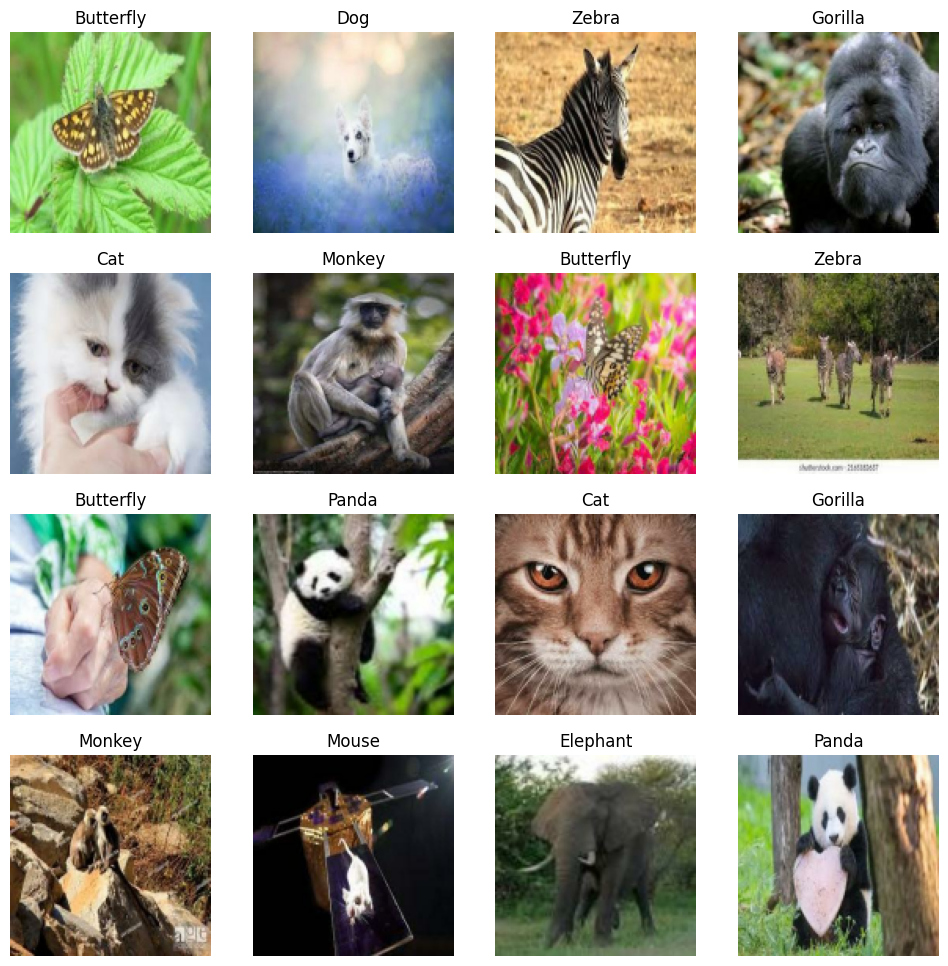

In [22]:
# Visualisation
# No matter how many times you run this cell, the images won't change.
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(fixed_images[i].astype("uint8"))
    plt.title(class_names[fixed_labels[i]])
    plt.axis("off")

### Performance Optimisation

Using `tf.data.AUTOTUNE` and the specific method below creates an asynchronous pipeline—basically, it allows the CPU to prepare the next batch while the GPU is still processing the current one.

In [23]:
# AUTOTUNE allows TensorFlow to dynamically adjust the resource allocation 
# (like CPU threads) based on your hardware's current workload at runtime.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    # Keep the data in memory (RAM) after the first epoch.
    # This prevents the CPU from having to re-read and re-decode JPEGs 
    # from the slow hard drive during every subsequent training round.
    .cache()

    # Maintain a buffer of 1,000 samples and randomly pulls from it.
    # This ensures the model doesn't learn the order of the files, 
    # but rather the features of the images.
    .shuffle(1000)

    # Overlaps the data preprocessing and model execution.
    # While the GPU is training on the current batch, the CPU is already 
    # preparing the next batch in the background. This eliminates "GPU starvation."
    .prefetch(buffer_size=AUTOTUNE)
)

In [24]:
validation_dataset = (
    validation_dataset
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### Data Augmentation (Modern Keras Layers)

In [25]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [26]:
# Instantiate Base Model

INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH) + (3,)

base_model = tf.keras.applications.ResNet101(
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    include_top=False,
)

base_model.trainable = False

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
base_model.summary()

Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,658,176 (162.73 MB)

In [28]:
# Define the input tensor, apply data augmentation to improve generalisation
# and preprocess images to match ResNet's expected input format.

inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)

In [29]:
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [30]:
# Add a classification head

x = tf.keras.layers.Dense(units=256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

In [31]:
number_classes

15

In [32]:
# Add the outputs
outputs = tf.keras.layers.Dense(number_classes, activation="softmax")(x)

In [33]:
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128, 128)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128, 128)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 128, 128)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 128, 128,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet101           │ (None, 4, 4,      │ 42,658,176 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet101[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 15)        │      1,935 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,922,383 (163.74 MB)

 Trainable params: 264,207 (1.01 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

### Build and Compile the Model

In [34]:
# Compile the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

### Configure Callbacks

In [35]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/best_animal_cnn.keras",
    monitor="val_accuracy",
    save_best_only=True,
    # verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=5,
    verbose=1
)


callbacks = [model_checkpoint, early_stopping, reduce_learning_rate]

### Train the model to learn patterns from the images

In [36]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/300


I0000 00:00:1768012991.137567     144 cuda_dnn.cc:529] Loaded cuDNN version 91002


938/938 ━━━━━━━━━━━━━━━━━━━━ 131s 86ms/step - accuracy: 0.6730 - loss: 1.1306 - val_accuracy: 0.8765 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 2/300
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - accuracy: 0.7987 - loss: 0.6554 - val_accuracy: 0.8970 - val_loss: 0.3450 - learning_rate: 0.0010
Epoch 3/300
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.8133 - loss: 0.6035 - val_accuracy: 0.9090 - val_loss: 0.3231 - learning_rate: 0.0010
Epoch 4/300
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 0.8241 - loss: 0.5646 - val_accuracy: 0.8995 - val_loss: 0.3307 - learning_rate: 0.0010
Epoch 5/300
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 0.8313 - loss: 0.5494 - val_accuracy: 0.8960 - val_loss: 0.3632 - learning_rate: 0.0010
Epoch 6/300
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 0.8346 - loss: 0.5418 - val_accuracy: 0.9000 - val_loss: 0.3217 - learning_rate: 0.0010
Epoch 7/300
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 0.8414 - loss:

### Plot Training Curves (Learning Dynamics)

In [37]:
def plot_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))


    plt.figure(figsize=(18, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()


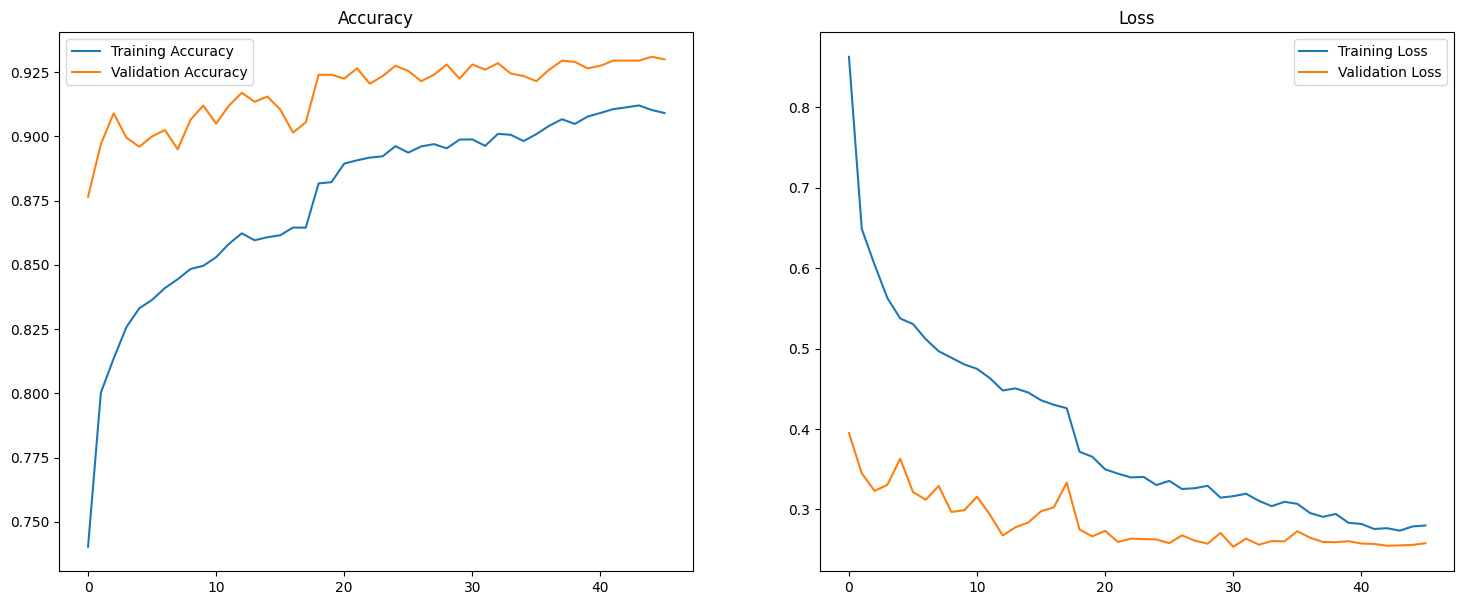

In [38]:
plot_learning_curves(history)

### Generate Predictions (TensorFlow to NumPy)

In [39]:
loss, accuracy = model.evaluate(validation_dataset)

print(f"Model Loss: {loss:.2f}")
print(f"Model Accuracy: {accuracy:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9255 - loss: 0.2872
Model Loss: 0.25
Model Accuracy: 0.93


In [40]:
y_true = []
y_pred = []
y_prob = []

for images, labels in validation_dataset:
    preds = model.predict(images, verbose=1) # Try verbose=0
    y_prob.append(preds)
    y_pred.append(np.argmax(preds, axis=1))
    y_true.append(labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━

In [41]:
len(y_true), len(y_pred), len(y_prob)

(63, 63, 63)

In [42]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)

### Core Classification Metrics (from scikit-learn)

In [43]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)



print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.2f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average="macro"):.2f}")
print(f"F1-score (macro): {f1_score(y_true, y_pred, average="macro"):.2f}")

Accuracy: 0.93
Precision (macro): 0.93
Recall (macro): 0.93
F1-score (macro): 0.93


In [44]:
# Full Classification Report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


              precision    recall  f1-score   support

      Beetle     0.9552    0.9600    0.9576       200
   Butterfly     0.9529    0.9100    0.9309       200
         Cat     0.9223    0.9500    0.9360       100
         Cow     0.8981    0.9700    0.9327       100
         Dog     0.9778    0.8800    0.9263       100
    Elephant     0.9423    0.9800    0.9608       100
     Gorilla     0.9083    0.9900    0.9474       100
       Hippo     0.9333    0.9800    0.9561       100
      Lizard     0.8889    0.9200    0.9042       200
      Monkey     0.7925    0.8400    0.8155       100
       Mouse     0.9558    0.8650    0.9081       200
       Panda     0.9151    0.9700    0.9417       100
      Spider     0.9391    0.9250    0.9320       200
       Tiger     0.9314    0.9500    0.9406       100
       Zebra     0.9889    0.8900    0.9368       100

    accuracy                         0.9280      2000
   macro avg     0.9268    0.9320    0.9285      2000
weighted avg     0.9297   

In [45]:
# cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# plt.figure(figsize=(14, 12))
# sns.heatmap(cm_norm, cmap="Blues", cbar=False, annot=True,
#             xticklabels=class_names, yticklabels=class_names)
# plt.title("Confusion Matrix (Normalized)")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.xticks(rotation=45, ha="right")
# plt.show()

In [46]:
# ROC–AUC (One-vs-Rest, Multi-Class)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_true_bin = label_binarize(y_true, 
                            classes=range(number_classes))

roc_auc_macro = roc_auc_score(
    y_true_bin,
    y_prob,
    average="macro",
    multi_class="ovr"
)

roc_auc_weighted = roc_auc_score(
    y_true_bin,
    y_prob,
    average="weighted",
    multi_class="ovr"
)

print("ROC-AUC (macro):", roc_auc_macro)
print("ROC-AUC (weighted):", roc_auc_weighted)


ROC-AUC (macro): 0.9975436744639378
ROC-AUC (weighted): 0.9974076169590643


In [47]:
# Precision–Recall AUC (PR-AUC)

from sklearn.metrics import average_precision_score

pr_auc_macro = average_precision_score(
    y_true_bin,
    y_prob,
    average="macro"
)

pr_auc_weighted = average_precision_score(
    y_true_bin,
    y_prob,
    average="weighted"
)

print("PR-AUC (macro):", pr_auc_macro)
print("PR-AUC (weighted):", pr_auc_weighted)

PR-AUC (macro): 0.9782875753232539
PR-AUC (weighted): 0.9789368498319789


In [48]:
# Top-K Accuracy (Important for 90 Classes)

top_5_acc = tf.keras.metrics.top_k_categorical_accuracy(
    y_true_bin,
    y_prob,
    k=5
).numpy().mean()

print("Top-5 Accuracy:", top_5_acc)


Top-5 Accuracy: 0.9895


In [49]:
# TensorFlow Native Metrics

tf_acc = tf.keras.metrics.SparseCategoricalAccuracy()
tf_acc.update_state(y_true, y_prob)
print("TF Accuracy:", tf_acc.result().numpy())

TF Accuracy: 0.928


In [50]:
# Saving the Model

model.save("animalsVGG16_V2.keras")

**This resulted in a poor model. We will use transfer learning to see how to improve the model using any of the model which is already doing well in general image processing tasks.**